In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from scipy import ndimage
from scipy.stats import entropy
from random import random
from sklearn.cluster import SpectralBiclustering
import sklearn.metrics as metrics
import itertools

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.orca.config.use_xvfb = False
plotly.io.orca.config.save()

import importlib
import trajectory as g

import nltk
nltk.download('punkt')

from collections import Counter

[nltk_data] Downloading package punkt to /Users/will/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

# Human Data

### load in data

In [3]:
iteration_name = 'Exp2Pilot3_all'
num_trials = 24 #for sanity checks

In [4]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

105 participants total


### apply preprocessing

In [5]:
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

dfic = dfi.copy()
#dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['targetName','gameID','blockNum','repetition','phase_extended','flatDiscreteWorld','usableDiscreteWorld','rawF1DiscreteScore']]
dfic['discreteWorld'] = dfic['usableDiscreteWorld']
dfic['flatDiscreteWorldStr'] = dfic['flatDiscreteWorld'].apply(g.convert_to_str)

max_actions = dfic['blockNum'].max()

In [6]:
def add_ngrams_to_dict(world_states, n, counts):
    n_grams = nltk.ngrams(world_states, n)
    for grams in n_grams:
        counts[' '.join(grams)] = counts.get(' '.join(grams), 0) + 1

def gini_coefficient(visits):
    visits = np.array(visits)[:,None]
    numerator = np.sum(metrics.pairwise_distances(visits))
    denomenator = 2 * (len(visits)**2) * np.mean(visits)
    if denomenator == 0:
        g = 0
    else:
        g = numerator/denomenator
    return g

In [8]:
results_h = pd.DataFrame(columns=['targetName','phase','gini'])

G = {}
for target in targets:
    G[target] = {}
    for phase in ['pre','post']:
        G[target][phase] = {}
        df_phase = dfic[(dfic.targetName==target) & (dfic.phase_extended==phase)]
        for n in range(1,11):
            counts = {}
            df_phase.groupby(['gameID'])['flatDiscreteWorldStr']\
                        .agg(lambda ws: add_ngrams_to_dict(list(ws),n,counts))
            visits = list(counts.values())
            G[target][phase][n] = gini_coefficient(visits)

#     target_df = pd.DataFrame.from_dict(G[target])
#     target_df['n'] = target_df.index
#     target_df = target_df.melt()\
#                         .rename(columns={'variable':'iter','value':'gini'})
    
#     target_df['targetName'] = target
#     results = results.append(this,sort=False)
            
for target in targets:
    target_df = pd.DataFrame.from_dict(G[target],orient='index')
    target_df.columns = target_df.columns.map(lambda x: 'gini'+str(x))
    target_df['phase'] = target_df.index
    target_df = pd.wide_to_long(target_df, stubnames='gini', i=['phase'], j='nlevel')
    target_df['targetName'] = target
    target_df = target_df.reset_index()
    results_h = results_h.append(target_df,sort=False)

In [13]:
results_h = pd.DataFrame(columns=['targetName','phase','gini'])

G = {}

for target in targets:
    G[target] = {}
    for phase in ['pre','post']:
        G[target][phase] = {}
        df_phase = dfic[(dfic.targetName==target) & (dfic.phase_extended==phase)]
        for n in range(1,11):
            counts = {}
            df_phase.groupby(['gameID'])['flatDiscreteWorldStr']\
                        .agg(lambda ws: add_ngrams_to_dict(list(ws),n,counts))
            visits = list(counts.values())
            G[target][phase][n] = gini_coefficient(visits)
            
        

[28, 7, 5, 2, 29, 7, 4, 5, 55, 50, 4, 5, 1, 1, 1, 13, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 11, 5, 5, 1, 9, 4, 2, 2, 1, 1, 1, 1, 1, 6, 1, 3, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 6, 3, 5, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 11, 5, 1, 1, 5, 4, 4, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 6, 1, 3, 2, 1, 1, 4, 3, 2, 1, 1, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1, 4, 2, 5, 3, 1, 1, 1, 6, 1, 5, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1

[3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 6, 6, 1, 1, 1, 1, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1, 2, 2, 1, 6, 2, 1, 1, 1, 1, 3, 10, 8, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[48, 12, 5, 2, 1, 1, 20, 4, 1, 5, 1, 1, 1, 40, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 16, 23, 12, 4, 1, 1, 1, 1, 1, 2, 2, 1, 1, 34, 2, 10, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 20, 11, 5, 7, 3, 3, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 8, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 2, 5, 5, 7, 8, 7, 7, 7, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[30, 64, 21, 9, 28, 6, 1, 1, 1, 1, 3, 1, 2, 12, 7, 1, 1, 5, 9, 4, 1, 1, 1, 1, 2, 2, 5, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 9, 5, 3, 14, 35, 4, 1, 1, 1, 1, 14, 1, 3, 4,

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[2, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1, 2, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 5, 5, 2, 3, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5, 4, 3, 3, 1, 2, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 

In [22]:
def get_ngrams(world_states, n):
    return nltk.ngrams(world_states, n)

In [33]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)

np.array(targetMaps[targets[0]]).astype(int)

(1*np.logical_not(target)-1)*(-100)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [49]:
(1*np.logical_not(targetMaps[target]))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [64]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)


def show_chunk(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    start_state_int = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state_int = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state_int, end_state_int).astype(np.int)
    chunk_plus = end_state_int + chunk
    
    if target:
        chunk_plus = chunk_plus + (1*np.logical_not(targetMaps[target]))*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)
        
        
def show_chunk_steps(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    
    start_state = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state, end_state).astype(np.float)
    
    chunk_plus = end_state.astype(np.float) + chunk
    
    
    for s in states[:-1]:
        chunk_plus -= np.reshape(list(s),(18,13)).astype(np.float)*0.2
    
    if target:
        chunk_plus = chunk_plus - (1*np.logical_not(targetMaps[target]))*0.4
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)

In [54]:
## For one structure, for one length

# filter for one structure
target = targets[1]
df_target = dfic[(dfic.targetName==target)]

# make a dataframe grouped by each time it is built (gameID, phase)
df_target_grouped = df_target.groupby(['gameID','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for those groups
n = 5
ngram_series = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), n))).reset_index()['flatDiscreteWorldStr']

ngram_list = [ngram for row in ngram_series for ngram in row]

# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

# Go through and count occurrences of each

ngram_counts = Counter(ngram_list)

# Return top k
k = 5
top_k = ngram_counts.most_common(k)

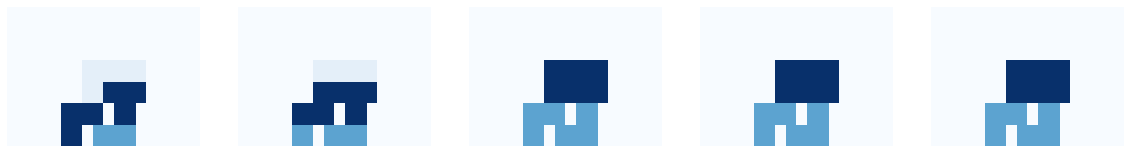

In [57]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(1, k, figsize=(20,6))

for j in range(0,k):
    start_state = top_k[j][0][0]
    end_state = top_k[j][0][n-1]

    axs[j].axis('off')
    
    show_chunk(top_k[j][0], axs[j], target=target)
    

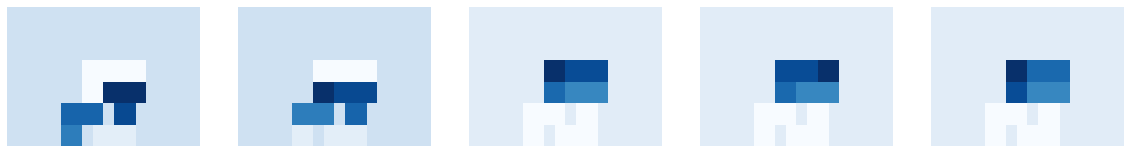

In [65]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(1, k, figsize=(20,6))

for j in range(0,k):
    states = top_k[j][0]
    axs[j].axis('off')
    show_chunk_steps(states, axs[j], target=target)
    

### ngrams to identify chunks

In [261]:
# this method uses sequences of states to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_size = 5 # number of blocks + 1 for initial state
k = 5 # take top k most frequent chunks

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for each reconstruction
df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

ngram_list = {}
ngram_counts = {}
top_k = {}

for t in targets:
    # for each target, put the ngrams from all reconstructions into list
    ngram_list[t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
    ngram_counts[t] = Counter(ngram_list[t]) # count occurrences of each ngram across ppts
    top_k[t] = ngram_counts[t].most_common(k)
    
# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

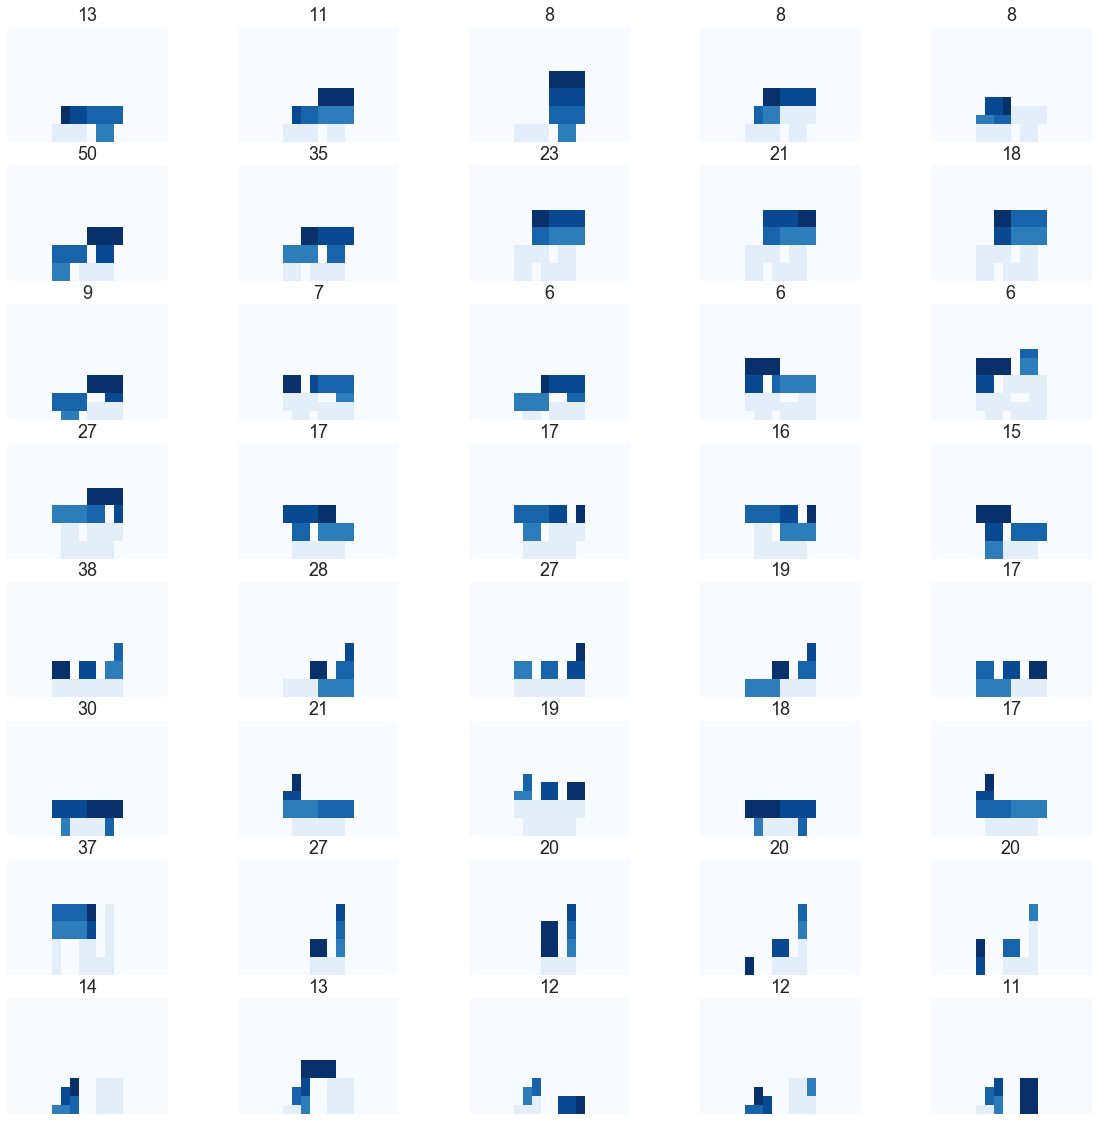

In [263]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(len(targets), k, figsize=(20,20))

for i, t in enumerate(targets):
    for j in range(0,k):
        states = top_k[t][j][0]

        axs[i,j].axis('off')
        axs[i,j].set_title(str(top_k[t][j][1]))

        show_chunk_steps(states, axs[i,j])

## Next steps!

### definition of chunks
Currently this is only displaying n-1 blocks, because the first state of the ngram is just that- a state.

An easier next step is to group by start state and end state (so not ngrams.. call them ngaps?!), but this makes them dependent on the starting state. This might end up being useful, but I think it's more likely chunks are at least separable from their initial state- so multiple states could be in the 'input set'. 

So the next step would be to look at the *difference* ('∆world') in world state (i.e. independent of starting state). 
Although these could also have a variable numbers of blocks- we'd need a way of choosing start and end states.
We could compute them all? Presumably there would be a lots near the beginning, and lots that spanned the whole trial (i.e. building the whole structure). 
But we could find mid-sized areas somehow- what defines a mid-sized area? Not number of blocks (but I guess they would have to be more than one block, so maybe any ∆world that takes a minimum of two blocks, and isn't the whole or nearly the whole structure).
(would/could we make these translation-invariant?)


Both of these methods are unconstrained by spatial continuity, which maybe should be a factor.




### first and last states

In [272]:
# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_size = 5 # number of blocks + 1 for initial state
k = 5 # take top k most frequent chunks

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for each reconstruction
df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

ngram_list = {}
first_last = {}
first_last_counts = {}
top_k_first_last = {}

for t in targets:
    # for each target, put the ngrams from all reconstructions into list
    ngram_list[t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
    first_last[t] = [(ngram[0], ngram[-1]) for ngram in ngram_list[t]]
    first_last_counts[t] = Counter(first_last[t]) # count occurrences of each ngram across ppts
    top_k_first_last[t] = first_last_counts[t].most_common(k)
    
# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

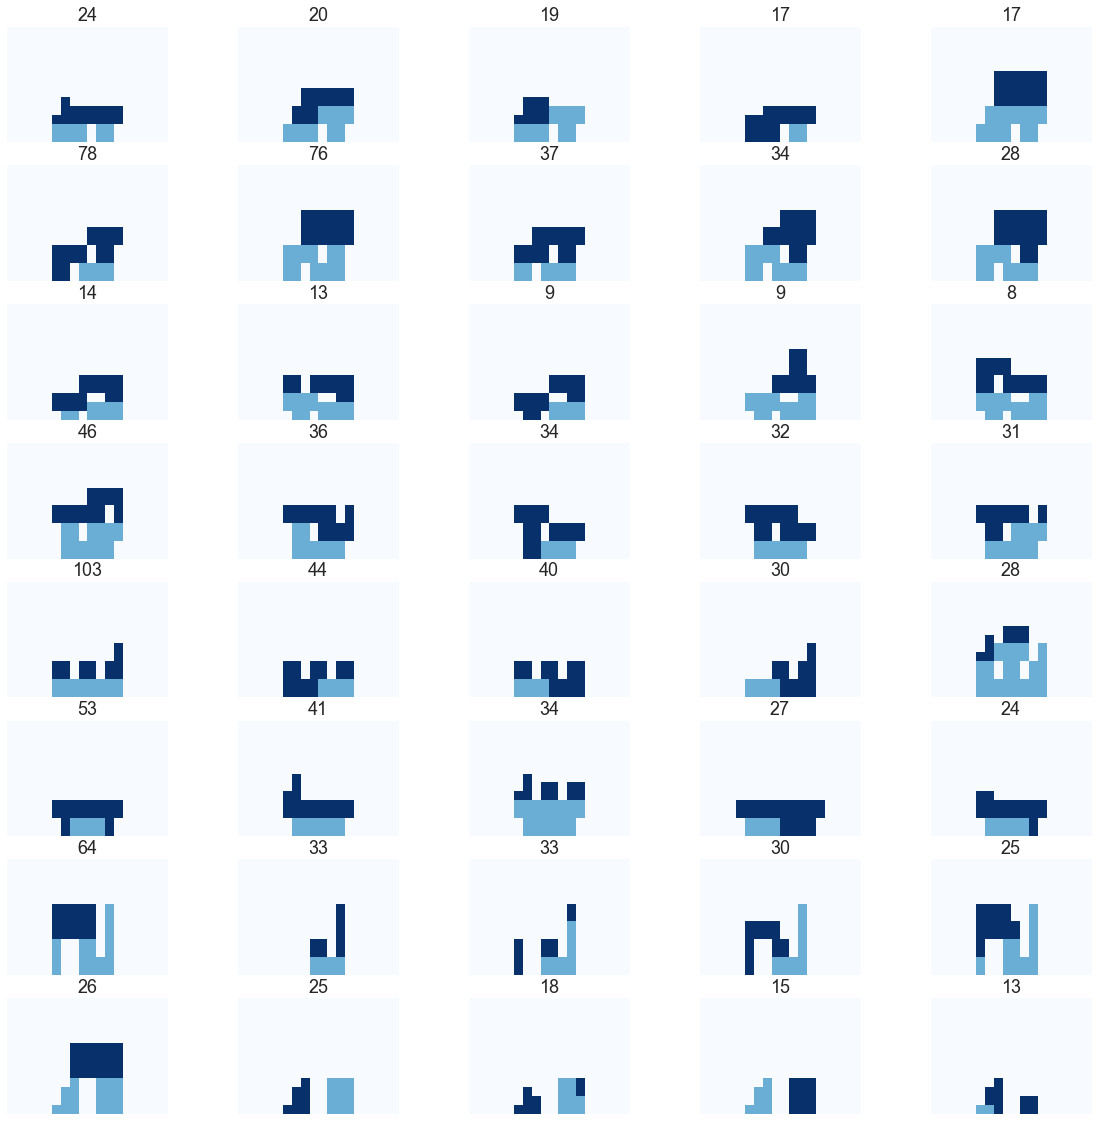

In [273]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(len(targets), k, figsize=(20,20))

for i, t in enumerate(targets):
    for j in range(0,k):
        states = top_k_first_last[t][j][0]

        axs[i,j].axis('off')
        axs[i,j].set_title(str(top_k_first_last[t][j][1]))

        show_chunk(states, axs[i,j])


As before, this method relies on the same start state.

In [16]:
# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_size = 5 # number of blocks + 1 for initial state
k = 5 # take top k most frequent chunks

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for each reconstruction
df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

ngram_list = {}
diff = {}
diff_counts = {}
top_k_diff = {}

for t in targets:
    # for each target, put the ngrams from all reconstructions into list
    ngram_list[t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
    diff[t] = ["".join([str(a) for a in 
                  list((np.array(list(ngram[-1])).astype(np.int) - 
                     np.array(list(ngram[0])).astype(np.int)))]) for ngram in ngram_list[t]]
#     diff[t] = ["".join([str(a) for a in
#                         [(np.array(list(ngram[-1])).astype(np.int) - 
#                          np.array(list(ngram[0])).astype(np.int)) for ngram in ngram_list[t]]])]

    diff_counts[t] = Counter(diff[t]) # count occurrences of each ngram across ppts
    top_k_diff[t] = diff_counts[t].most_common(k)

    
# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

In [24]:
top_k_diff[t][j]

('000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111000000000111100000000011110000000001111000000000111100000000011110000000000000000000000000000000000000000000000000000000000000000000000',
 32)

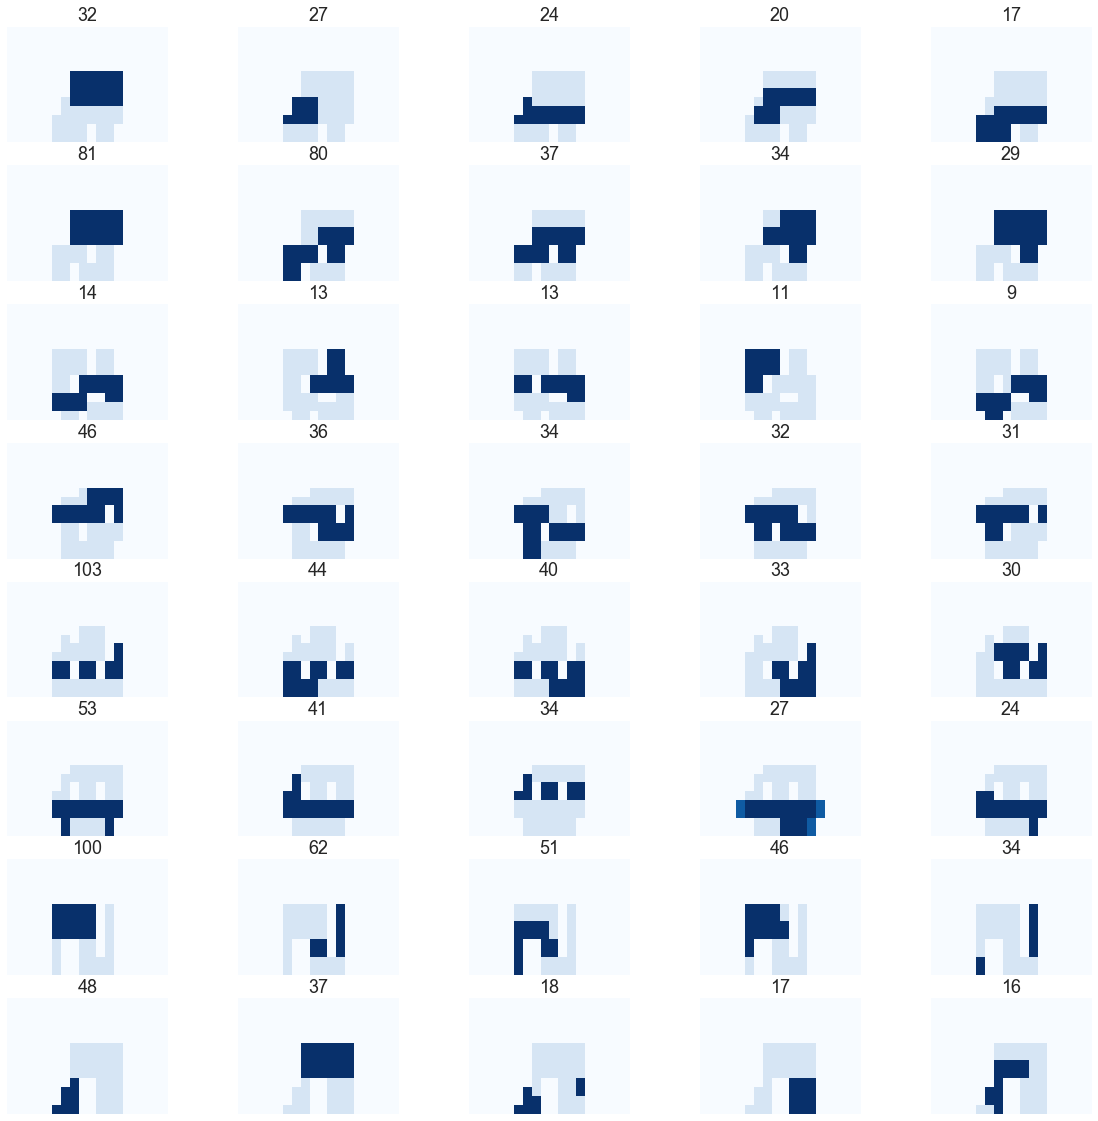

In [66]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(len(targets), k, figsize=(20,20))

for i, t in enumerate(targets):
    for j in range(0,k):
        states = [top_k_diff[t][j][0]]

        axs[i,j].axis('off')
        axs[i,j].set_title(str(top_k_diff[t][j][1]))

        show_chunk(states, axs[i,j], target=t)


In [353]:
! git

[master ca78e89] more chunk analysis
 1 file changed, 1186 insertions(+), 35 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 8 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 101.45 KiB | 6.76 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: 
remote: GitHub found 1 vulnerability on cogtoolslab/block_construction's default branch (1 high). To find out more, visit:
remote:      https://github.com/cogtoolslab/block_construction/network/alert/experiments/package.json/mongodb/open
remote: 
To https://github.com/cogtoolslab/block_construction.git
   df47dc5..ca78e89  master -> master
